Czytanie plików fio i dd

In [1]:
import os
import re
from collections import defaultdict
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [18]:
def parse_fio_results(file_path):
    # Regular expressions
    bandwidth_regex = re.compile(r'WRITE: bw=(\d+(?:\.\d+)?)([MK]iB/s)')
    bandwidth_read_regex = re.compile(r'READ: bw=(\d+(?:\.\d+)?)([MK]iB/s)')
    iops_regex = re.compile(r'write: IOPS=(\d+)')
    iops_read_regex = re.compile(r'read: IOPS=(\d+)')
    latency_regex = re.compile(r'lat (\([mu]sec\)): min=\d+\.?\d*[km]?, max=\d+\.?\d*[km]?, avg=(\d+\.\d+[km]?), stdev=\d+\.?\d*')

    # Function to convert bandwidth to MiB/s
    def convert_bandwidth(value, unit):
        value = float(value)
        if unit == "KiB/s":
            return value / 1024  # Convert KiB/s to MiB/s
        return value  # Already in MiB/s

    results = {}

    with open(file_path, 'r') as file:
        last = 'read'
        for line in file:
            # Match write bandwidth
            if 'write' in line:
                last = 'write'
            elif 'read' in line:
                last = 'read'
            bw_match = bandwidth_regex.search(line)
            if bw_match:
                value, unit = bw_match.groups()
                results['Bandwidth WRITE (MiB/s)'] = convert_bandwidth(value, unit)

            # Match read bandwidth
            bw_read_match = bandwidth_read_regex.search(line)
            if bw_read_match:
                value, unit = bw_read_match.groups()
                results['Bandwidth READ (MiB/s)'] = convert_bandwidth(value, unit)

            # Match write IOPS
            iops_match = iops_regex.search(line)
            if iops_match:
                results['IOPS WRITE'] = float(iops_match.group(1))

            # Match read IOPS
            iops_read_match = iops_read_regex.search(line)
            if iops_read_match:
                results['IOPS READ'] = float(iops_read_match.group(1))

            # Match latency
            lat_match = latency_regex.search(line)
            if lat_match:
                lat_val = float(lat_match.group(2))
                if lat_match.group(1) == '(usec)':
                    lat_val /= 1000
                if last == 'read':
                    results['Latency READ (ms)'] = lat_val
                else:
                    results['Latency WRITE (ms)'] = lat_val

    return results

def parse_dd_results(file_path):
    # Regular expressions
    bandwidth_regex = re.compile(r'(\d+(?:\.\d+)?) ([GMK]B/s)')
    time_regex = re.compile(r'(\d+(?:\.\d+)?) s')

    # Function to convert bandwidth to MiB/s
    def convert_bandwidth(value, unit):
        value = float(value)
        if unit == "KB/s":
            return value / 1024  # Convert KB/s to MiB/s
        elif unit == "MB/s":
            return value  # Already in MiB/s
        elif unit == "GB/s":
            return value * 1024  # Convert GB/s to MiB/s
        return value

    results = {}

    with open(file_path, 'r') as file:
        for line in file:
            # Match bandwidth
            bw_match = bandwidth_regex.search(line)
            if bw_match:
                value, unit = bw_match.groups()
                if 'write' in file_path:
                    results['Bandwidth WRITE (MiB/s)'] = convert_bandwidth(value, unit)
                else:
                    results['Bandwidth READ (MiB/s)'] = convert_bandwidth(value, unit)

            # Match time
            time_match = time_regex.search(line)
            if time_match:
                results['Time (s)'] = float(time_match.group(1))

    return results

import re

import re

def extract_values(resultsfolder, file_names, parser, program_type):
    resultsdict = {'ext4': {}, 'xfs': {}, 'btrfs': {}, 'zfs': {}, 'f2fs': {}}
    
    # Funkcja pomocnicza do wyodrębnienia nazwy od drugiego słowa do słowa "test"
    def extract_key(file_name):
        match = re.match(r"^[^_]+_(.*?)_test", file_name)  # Pomija pierwsze słowo przed "_"
        return match.group(1) if match else os.path.splitext(file_name)[0]

    prepaths = [folder for folder in glob.glob(resultsfolder + '*/') if program_type in folder]  # Filtruj według typu programu
    for prepath in prepaths:
        filesystem = prepath.split('\\')[-2].split('_')[2]
        storage = prepath.split('\\')[-2].split('_')[3]
        
        # Sprawdź, czy typ programu używa folderów z rozmiarem bloków
        if program_type in ['fio_results', 'dd_results']:
            block_size_folders = [folder for folder in glob.glob(prepath + '*/')]  # Uwzględnij foldery z rozmiarem bloków
            for block_size_folder in block_size_folders:
                # Bezpiecznie wyodrębnij rozmiar bloku
                folder_parts = block_size_folder.split('\\')[-2].split('_')
                if len(folder_parts) > 2 and folder_parts[0] == "block" and folder_parts[1] == "size":
                    block_size = folder_parts[2]
                else:
                    print(f"Pomijanie folderu o nieoczekiwanej strukturze: {block_size_folder}")
                    continue

                folders = [folder for folder in glob.glob(block_size_folder + '*/')]
                cumulative_data = {}
                for folder in folders:
                    for file_name in file_names:
                        file_path = os.path.join(folder, file_name)
                        if os.path.exists(file_path):
                            try:
                                results = parser(file_path)
                                if results:  # Dodaj tylko, jeśli są jakieś dane
                                    test_key = extract_key(file_name)
                                    if test_key not in cumulative_data:
                                        cumulative_data[test_key] = defaultdict(list)
                                    for key, value in results.items():
                                        cumulative_data[test_key][key].append(value)
                            except Exception as e:
                                print(f"Błąd podczas parsowania {file_path}: {e}")
                        else:
                            print(f"Plik nie znaleziony: {file_path}")

                ranges = {}
                for test_key, metrics in cumulative_data.items():
                    if metrics:  # Dodaj tylko, jeśli są jakieś dane
                        ranges[test_key] = {
                            key: {'min': round(min(values), 3), 'max': round(max(values), 3), 'avg': round(sum(values) / len(values), 2)} if values else '-'
                            for key, values in metrics.items()
                        }
                if block_size not in resultsdict[filesystem]:
                    resultsdict[filesystem][block_size] = {}
                resultsdict[filesystem][block_size][storage] = ranges
        else:
            # Obsługa programów bez folderów z rozmiarem bloków (np. hdparm)
            folders = [folder for folder in glob.glob(prepath + '*/')]
            cumulative_data = {}
            for folder in folders:
                for file_name in file_names:
                    file_path = os.path.join(folder, file_name)
                    if os.path.exists(file_path):
                        try:
                            results = parser(file_path)
                            if results:  # Dodaj tylko, jeśli są jakieś dane
                                test_key = extract_key(file_name)
                                if test_key not in cumulative_data:
                                    cumulative_data[test_key] = defaultdict(list)
                                for key, value in results.items():
                                    cumulative_data[test_key][key].append(value)
                        except Exception as e:
                            print(f"Błąd podczas parsowania {file_path}: {e}")
                    else:
                        print(f"Plik nie znaleziony: {file_path}")

            ranges = {}
            for test_key, metrics in cumulative_data.items():
                if metrics:  # Dodaj tylko, jeśli są jakieś dane
                    ranges[test_key] = {
                        key: {'min': round(min(values), 3), 'max': round(max(values), 3), 'avg': round(sum(values) / len(values), 2)} if values else '-'
                        for key, values in metrics.items()
                    }
            if 'no_block_size' not in resultsdict[filesystem]:
                resultsdict[filesystem]['no_block_size'] = {}
            resultsdict[filesystem]['no_block_size'][storage] = ranges
    return resultsdict


def parse_hdparm_results(file_path):
    # Regular expression to match the bandwidth
    bandwidth_regex = re.compile(r'Timing O_DIRECT disk reads: (\d+(?:\.\d+)?) MB in .* seconds = (\d+(?:\.\d+)) MB/sec')

    results = {}

    with open(file_path, 'r') as file:
        for line in file:
            # Match bandwidth
            bw_match = bandwidth_regex.search(line)
            if bw_match:
                total_mb, bandwidth = bw_match.groups()
                results['Total Data Read (MB)'] = float(total_mb)
                results['Bandwidth (MiB/s)'] = float(bandwidth)

    return results
    
def extract_hdparm_values_by_device(resultsfolder, file_names, parser, group_by_computer=False):
    resultsdict = defaultdict(lambda: defaultdict(lambda: defaultdict(list))) if group_by_computer else defaultdict(lambda: defaultdict(list))

    # Iterate through all folders in the results folder
    prepaths = glob.glob(resultsfolder + '*/')  # Get all subfolders
    for prepath in prepaths:
        # Extract device type from the folder name (e.g., "hdparm_results_xfs_nvme")
        device_type = prepath.split('_')[-1].lower().strip('\\')  # Extract "nvme", "ssd", etc., and remove trailing slashes
        
        # Iterate through subfolders for each computer
        folders = glob.glob(prepath + '*/')  # Get subfolders for each computer
        for folder in folders:
            computer_name = folder.split('\\')[-2]  # Extract computer name (e.g., "lab-sec-13")
            for file_name in file_names:
                file_path = os.path.join(folder, file_name)
                if os.path.exists(file_path):
                    try:
                        # Parse the file and collect results
                        results = parser(file_path)
                        if group_by_computer:
                            for key, value in results.items():
                                resultsdict[device_type][computer_name][key].append(value)
                        else:
                            for key, value in results.items():
                                resultsdict[device_type][key].append(value)
                    except Exception as e:
                        print(f"Error parsing {file_path}: {e}")
                else:
                    print(f"File not found: {file_path}")

    # Aggregate results by calculating min, max, and avg for each metric
    aggregated_results = {}
    for device_type, computers_or_metrics in resultsdict.items():
        if group_by_computer:
            aggregated_results[device_type] = {}
            for computer, metrics in computers_or_metrics.items():
                aggregated_results[device_type][computer] = {
                    key: {
                        'min': round(min(values), 3),
                        'max': round(max(values), 3),
                        'avg': round(sum(values) / len(values), 2)
                    } if values else '-' for key, values in metrics.items()
                }
        else:
            aggregated_results[device_type] = {
                key: {
                    'min': round(min(values), 3),
                    'max': round(max(values), 3),
                    'avg': round(sum(values) / len(values), 2)
                } if values else '-' for key, values in computers_or_metrics.items()
            }

    return aggregated_results

In [19]:

# Example usage for fio
fio_file_names = [
    'fio_database_test_output.txt',
    'fio_multimedia_test_output.txt',
    'fio_webserver_test_output.txt',
    'fio_archive_test_output.txt',
    'fio_database_article_test_output.txt',
]

fio_resultsdict = extract_values('../wyniki_50G/', fio_file_names, parse_fio_results, program_type='fio_results')
print(fio_resultsdict)

# Example usage for dd
dd_file_names = [
    'dd_read_test_output.txt',
    'dd_write_test_output.txt',
]

dd_resultsdict = extract_values('../wyniki_50G/', dd_file_names, parse_dd_results, program_type='dd_results')
print(dd_resultsdict)

hdparm_file_names = [
    'hdparm_test_output.txt',
]

hdparm_resultsdict = extract_hdparm_values_by_device('../wyniki_50G/', hdparm_file_names, parse_hdparm_results, group_by_computer=False)

print(hdparm_resultsdict)

Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-1\fio_database_test_output.txt
Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-1\fio_multimedia_test_output.txt
Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-1\fio_webserver_test_output.txt
Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-1\fio_archive_test_output.txt
Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-13\fio_database_test_output.txt
Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-13\fio_multimedia_test_output.txt
Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-13\fio_webserver_test_output.txt
Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-13\fio_archive_test_output.txt
Plik nie znaleziony: ../wyniki_50G\fio_results_btrfs_hdd\block_size_4096\lab-sec-14\fio_database

Funkcja do generowania wykresów

In [20]:
def plot_performance_metrics(data, metrics, storage_types, block_sizes, include_min_max=False, workload=None, file_systems=None, colors=None, hdparm_data=None, hdparm_stat='avg', preserve_ylim=False):
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Default list of colors for different file systems
    
    if file_systems is None:
        file_systems = list(data.keys())  # Use all file systems if none are provided
    
    for block_size in block_sizes:
        for storage in storage_types:
            valid_metrics = []  # Use a list to preserve the order of addition
            for metric in metrics:
                for fs in file_systems:
                    if fs in data and block_size in data[fs] and storage.lower() in data[fs][block_size]:
                        results = data[fs][block_size][storage.lower()]
                        if workload:
                            if workload in results and results[workload].get(metric, {}):
                                if metric not in valid_metrics:  # Avoid duplicates
                                    valid_metrics.append(metric)
                        else:
                            for operation, metrics_data in results.items():
                                if metric in metrics_data:
                                    if metric not in valid_metrics:  # Avoid duplicates
                                        valid_metrics.append(metric)
            
            if not valid_metrics:
                continue  # Skip if there are no valid metrics for this storage type
            
            fig, axs = plt.subplots(len(valid_metrics), 1, figsize=(10, 3 * len(valid_metrics)))
            fig.suptitle(f'Performance Metrics for {storage} (Block Size: {block_size}){" - " + workload.capitalize() if workload else ""}')
            
            for i, metric in enumerate(valid_metrics):
                fs_labels = []
                avg_values = []
                min_values = []
                max_values = []
                color_map = {}
                for idx, fs in enumerate(file_systems):
                    if fs in data and block_size in data[fs] and storage.lower() in data[fs][block_size]:
                        results = data[fs][block_size][storage.lower()]
                        if workload:
                            if workload in results:
                                values = results[workload].get(metric, {})
                                if values:
                                    fs_labels.append(fs)
                                    avg_values.append(values['avg'])
                                    if include_min_max:
                                        min_values.append(values.get('min', values['avg']))
                                        max_values.append(values.get('max', values['avg']))
                                    color_map[fs] = colors[idx % len(colors)]  # Assign color to file system
                        else:
                            for operation, metrics_data in results.items():
                                if metric in metrics_data:
                                    values = metrics_data[metric]
                                    fs_labels.append(fs)
                                    avg_values.append(values['avg'])
                                    if include_min_max:
                                        min_values.append(values.get('min', values['avg']))
                                        max_values.append(values.get('max', values['avg']))
                                    color_map[fs] = colors[idx % len(colors)]  # Assign color to file system
                
                bars = axs[i].bar(fs_labels, avg_values, color=[color_map[fs] for fs in fs_labels])
                if include_min_max:
                    yerr = [np.array(avg_values) - np.array(min_values), np.array(max_values) - np.array(avg_values)]
                    yerr = np.abs(yerr)  # Ensure yerr does not contain negative values
                    axs[i].errorbar(fs_labels, avg_values, yerr=yerr, fmt='o', color='black')
                
                # Set Y-axis limits before adding the reference line
                if preserve_ylim:
                    y_min, y_max = axs[i].get_ylim()
                
                # Add hdparm reference line if provided and if the metric is related to bandwidth
                if hdparm_data and storage.lower() in hdparm_data and "Bandwidth" in metric:
                    hdparm_value = hdparm_data[storage.lower()].get('Bandwidth (MiB/s)', {}).get(hdparm_stat, None)
                    if hdparm_value is not None:
                        axs[i].axhline(y=hdparm_value, color='red', linestyle='--', label=f'hdparm {hdparm_stat.capitalize()}')
                        axs[i].legend()
                
                # Restore the original Y-axis limits if preserve_ylim is True
                if preserve_ylim:
                    axs[i].set_ylim(y_min, y_max)
                
                axs[i].set_title(metric)
                axs[i].set_ylabel(metric)
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

Funkcja do generowania tabelki fio

In [24]:
import pandas as pd

def generate_columns(metrics, stats=["MIN", "AVG", "MAX"], storage_types=["HDD", "SSD", "NVME"]):
    columns = ["File System", "Block Size"]
    for storage in storage_types:
        for metric in metrics:
            for stat in stats:
                columns.append(f"{storage} {metric} {stat}")
    return columns

def extract_row_data(data, workload, columns, file_systems=None, block_sizes=None):
    rows = []
    for fs, block_data in data.items():
        if file_systems and fs not in file_systems:
            continue
        for block_size, devices in block_data.items():
            if block_sizes and block_size not in block_sizes:
                continue
            row = [fs, block_size]
            for col in columns[2:]:  # Skip File System and Block Size
                if len(col.split()) > 3:
                    col = col.split()
                    storage, metric, stat = col[0], col[1] + ' ' + col[2], col[3]
                else:
                    storage, metric, stat = col.split(" ", 2)
                if workload == 'database':
                    if "Latency" in metric:
                        metric_key = f"{metric} (ms)"
                    else:
                        metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
                elif workload == 'archive':
                    if metric == "Latency":
                        metric_key = "Latency WRITE (ms)"
                    else:
                        metric_key = f"{metric} WRITE (MiB/s)" if metric == "Bandwidth" else f"{metric} WRITE"
                elif workload == 'dd':
                    metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
                else:
                    if metric == "Latency":
                        metric_key = "Latency READ (ms)"
                    else:
                        metric_key = f"{metric} READ (MiB/s)" if metric == "Bandwidth" else f"{metric} READ"
                # Extract value
                value = "N/A"
                for device_type, workloads in devices.items():
                    if device_type.lower() == storage.lower() and workload in workloads:
                        value = workloads[workload].get(metric_key, {}).get(stat.lower(), "N/A")
                        break
                row.append(value)
            rows.append(row)
    return rows

def display_performance_metrics(data, workloads, metrics, stats=["MIN", "AVG", "MAX"], storage_types=["HDD", "SSD", "NVME"], file_systems=None, block_sizes=None):
    for workload in workloads:
        columns = generate_columns(metrics, stats, storage_types)
        rows = extract_row_data(data, workload, columns, file_systems, block_sizes)
        df = pd.DataFrame(rows, columns=columns)
        display(df.style.set_caption(f"Performance Metrics: {workload.capitalize()}").format(precision=3))

# Example usage
#workloads = ["database", "multimedia", "webserver", "archive"]
workloads = ["database_article"]
metrics = {
    "database": ["Bandwidth READ", "Bandwidth WRITE", "IOPS READ", "IOPS WRITE", "Latency READ", "Latency WRITE"],
    "default": ["Bandwidth", "IOPS", "Latency"]
}
block_sizes = ["4096"]  # Specify block sizes to display

# Generate and display tables for each workload
for workload in workloads:
    print(workload)
    workload_metrics = metrics.get(workload, metrics["default"])
    display_performance_metrics(fio_resultsdict, [workload], workload_metrics, block_sizes=block_sizes)

database_article


,File System,Block Size,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD IOPS MIN,HDD IOPS AVG,HDD IOPS MAX,HDD Latency MIN,HDD Latency AVG,HDD Latency MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD IOPS MIN,SSD IOPS AVG,SSD IOPS MAX,SSD Latency MIN,SSD Latency AVG,SSD Latency MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME IOPS MIN,NVME IOPS AVG,NVME IOPS MAX,NVME Latency MIN,NVME Latency AVG,NVME Latency MAX
0,ext4,4096,1.001,1.050,1.080,128.000,133.920,138.000,488.800,516.610,545.020,1.019,13.470,71.900,130.000,1723.600,9199.000,6.119,428.760,547.070,65.000,71.190,76.900,8324.000,9113.300,9848.000,6.543,7.860,8.574
1,xfs,4096,1.122,1.140,1.150,143.000,145.000,147.000,477.450,487.030,493.870,1.124,13.660,72.900,143.000,1747.100,9329.000,6.019,393.810,495.200,61.900,79.700,94.000,10.000,2666.800,9338.000,5.401,6.350,8.218
2,btrfs,4096,2.139,2.150,2.178,273.000,275.300,278.000,301.500,304.000,308.050,2.136,17.440,79.500,10.000,1215.300,9945.000,3.887,244.410,307.510,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


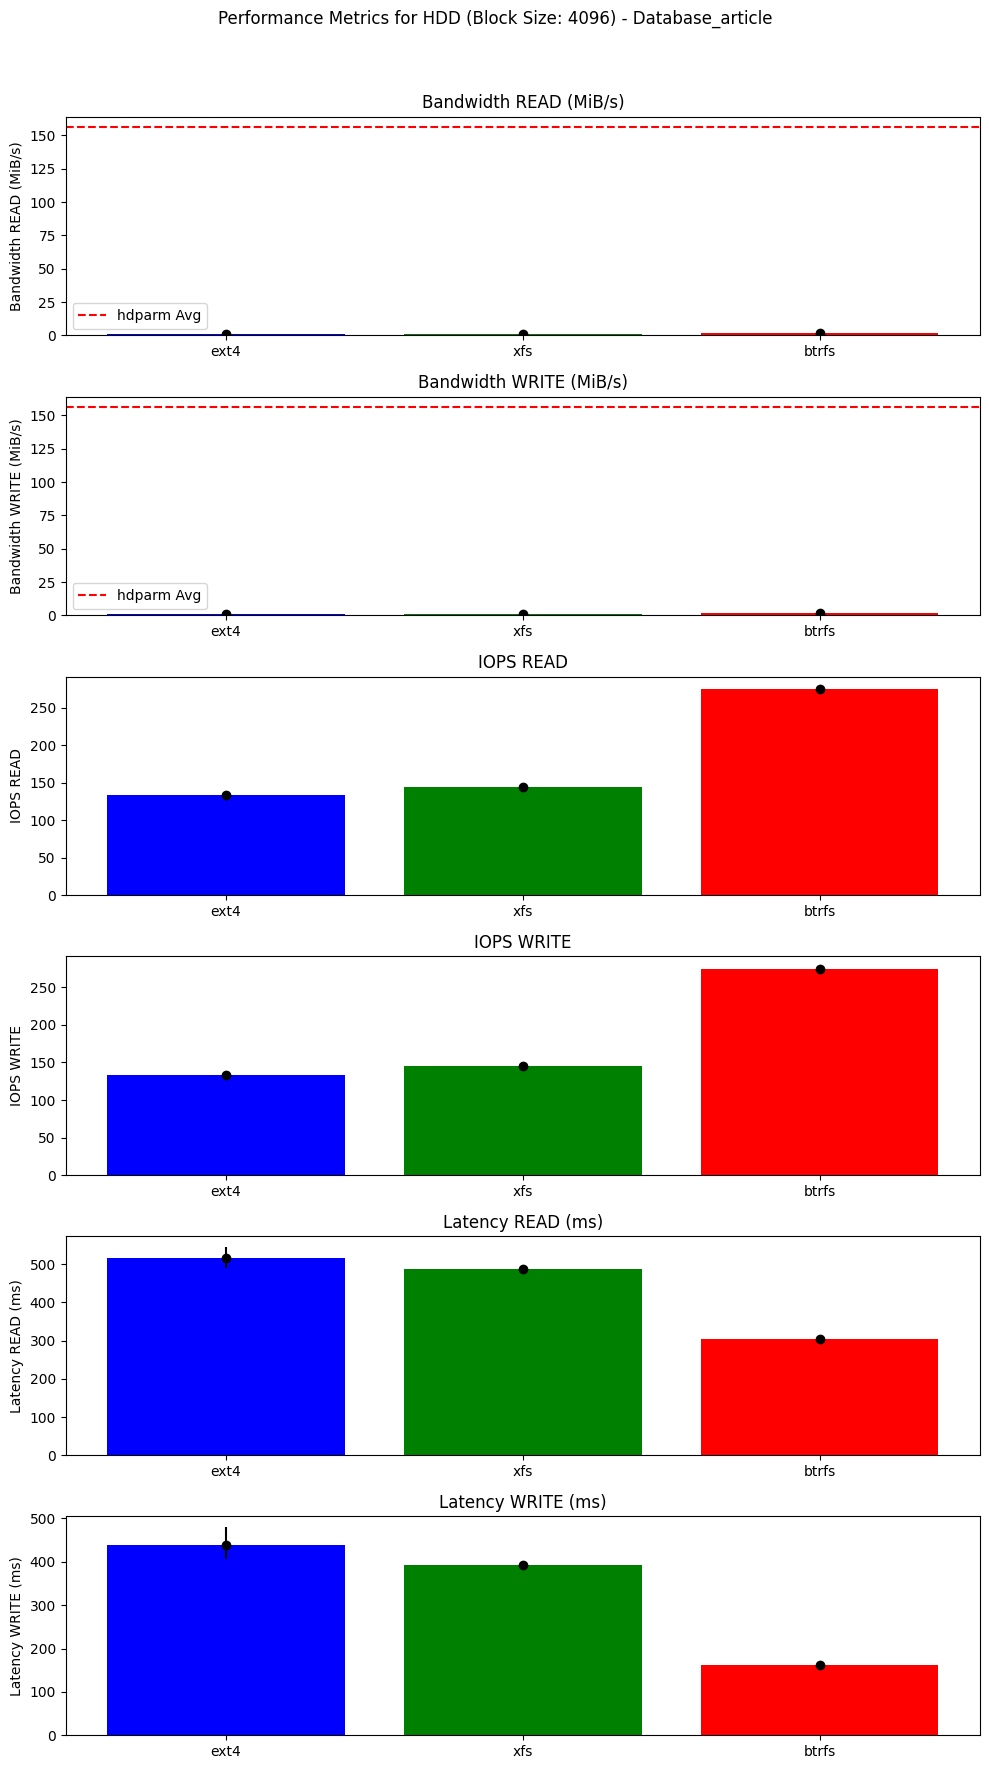

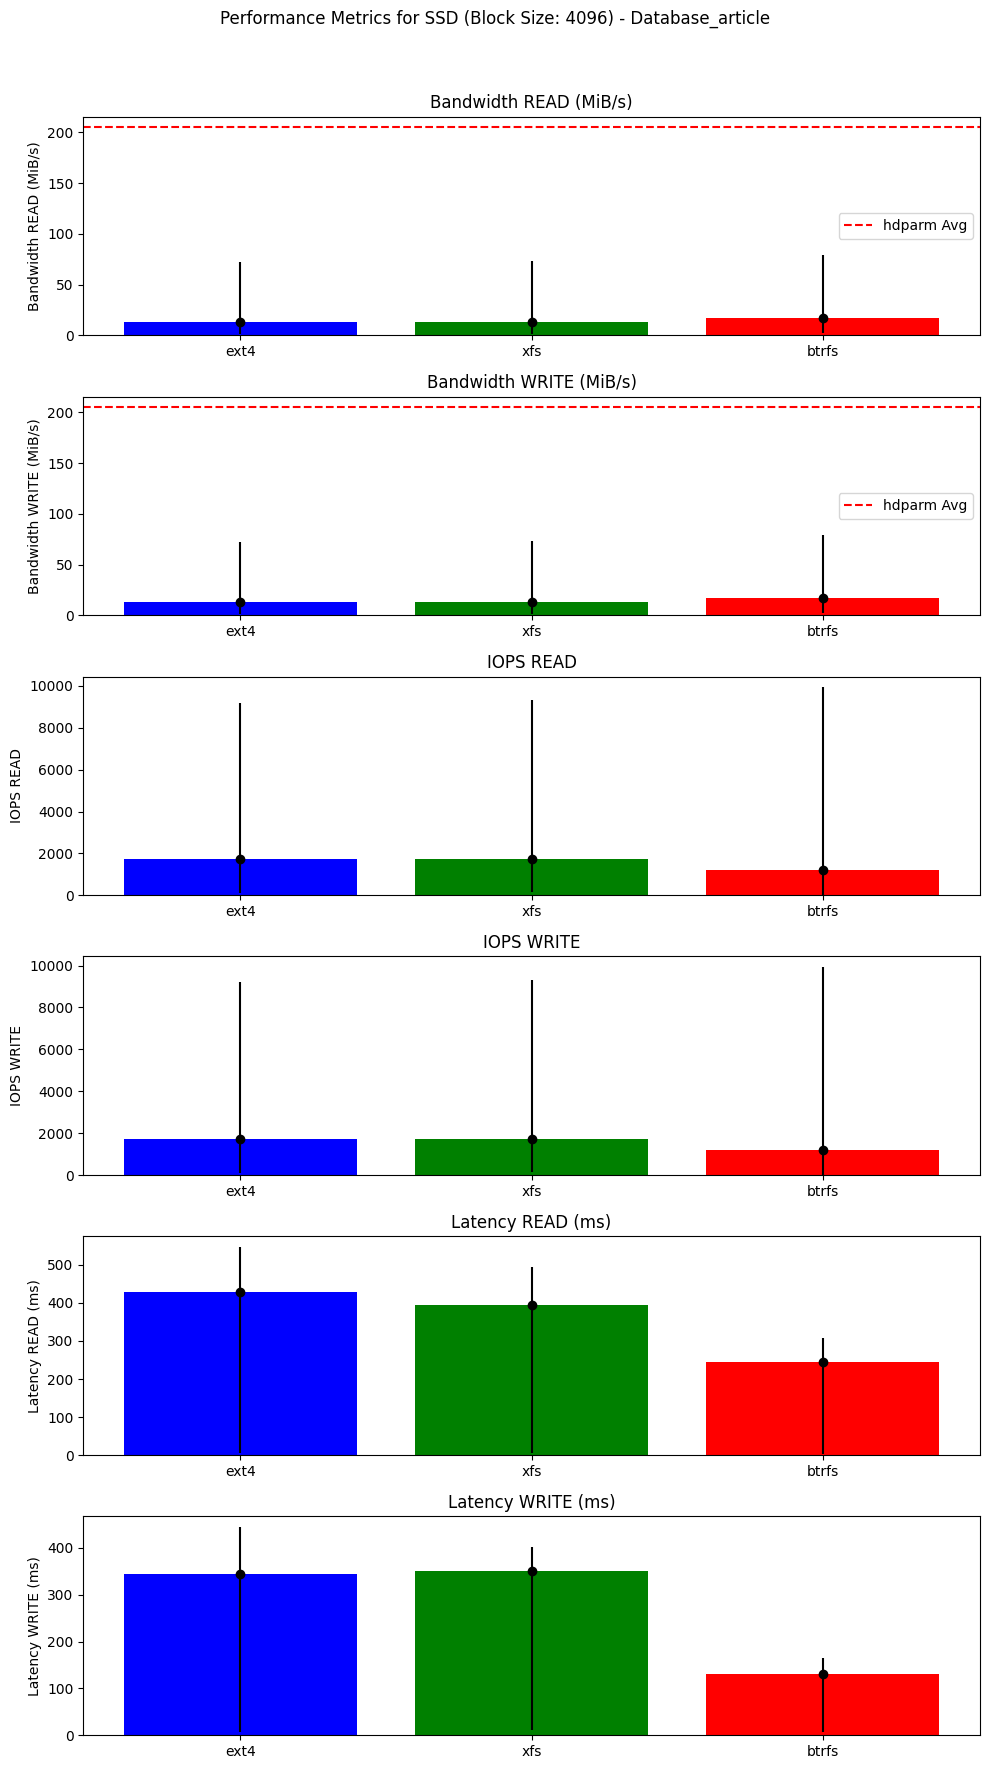

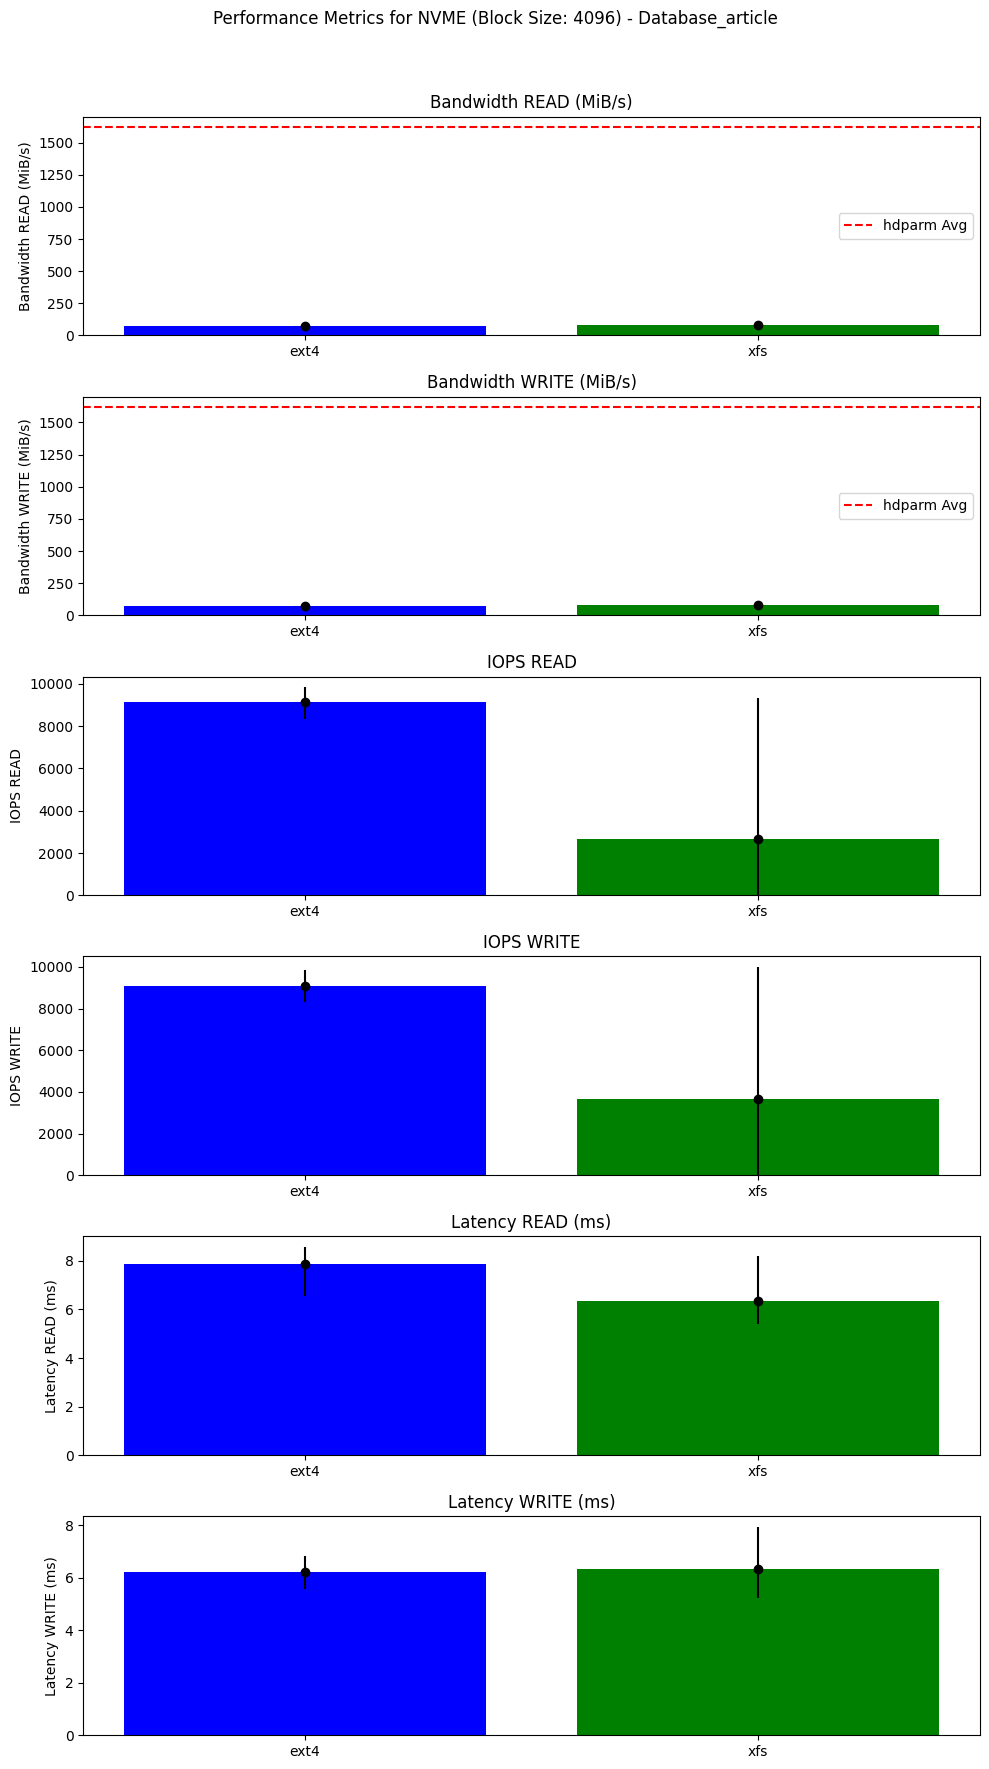

In [25]:

# Example usage
metrics = ["Bandwidth READ (MiB/s)", "Bandwidth WRITE (MiB/s)", "IOPS READ", "IOPS WRITE", "Latency READ (ms)", "Latency WRITE (ms)"]
storage_types = ['HDD', 'SSD', 'NVME']
block_sizes = ['4096']

# Plot performance metrics for fio data
#workloads = ["database", "multimedia", "webserver", "archive"]
workloads = ["database_article"]
for workload in workloads:
    plot_performance_metrics(fio_resultsdict, metrics, storage_types, block_sizes, include_min_max=True, workload=workload, hdparm_data=hdparm_resultsdict, hdparm_stat='avg' )



In [32]:
# Function to generate all possible columns
def generate_columns(metrics, stats=["MIN", "MAX", "AVG"], storage_types=["HDD", "SSD", "NVME"], file_systems=None):
    columns = ["File System", "Block Size"]  # Include Block Size in columns
    for storage in storage_types:
        for metric in metrics:
            for stat in stats:
                columns.append(f"{storage} {metric} {stat}")
    return columns

def extract_row_data(data, columns, file_systems=None, block_sizes=None):
    rows = []
    for fs, block_data in data.items():
        if file_systems and fs not in file_systems:
            continue
        for block_size, devices in block_data.items():  # Iterate over block sizes
            if block_sizes and block_size not in block_sizes:
                continue
            row = [fs, block_size]  # Add File System and Block Size to the row
            for col in columns[2:]:  # Skip File System and Block Size
                if len(col.split()) > 3:
                    col = col.split()
                    storage, metric, stat = col[0], col[1] + ' ' + col[2], col[3]
                else:
                    storage, metric, stat = col.split(" ", 2)
                metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
                # Extract value
                value = "N/A"
                for device_type, workloads in devices.items():
                    if device_type.lower() == storage.lower():
                        for operation, metrics in workloads.items():
                            if metric_key in metrics:
                                value = metrics[metric_key].get(stat.lower(), "N/A")
                                break
                row.append(value)
            rows.append(row)
    return rows

# Example data
# Generate and display tables for dd_resultsdict
print(dd_resultsdict)
columns = generate_columns(["Bandwidth READ", "Bandwidth WRITE"], stats=["MIN", "AVG", "MAX"], storage_types=["HDD", "SSD", "NVME"])
rows = extract_row_data(dd_resultsdict, columns, block_sizes=["4096"])  # Specify block sizes
df = pd.DataFrame(rows, columns=columns)
display(df.style.set_caption("Performance Metrics: DD Results").format(precision=3))

{'ext4': {'4096': {'hdd': {'read': {'Bandwidth READ (MiB/s)': {'min': 125.0, 'max': 165.0, 'avg': 150.17}, 'Time (s)': {'min': 6.511, 'max': 8.611, 'avg': 7.18}}, 'write': {'Bandwidth WRITE (MiB/s)': {'min': 144.0, 'max': 166.0, 'avg': 153.17}, 'Time (s)': {'min': 6.485, 'max': 7.439, 'avg': 7.02}}}, 'nvme': {'read': {'Bandwidth READ (MiB/s)': {'min': 1126.4, 'max': 1638.4, 'avg': 1290.24}, 'Time (s)': {'min': 0.662, 'max': 1.02, 'avg': 0.88}}, 'write': {'Bandwidth WRITE (MiB/s)': {'min': 111.0, 'max': 914.0, 'avg': 415.2}, 'Time (s)': {'min': 1.174, 'max': 9.68, 'avg': 4.06}}}, 'ssd': {'read': {'Bandwidth READ (MiB/s)': {'min': 148.0, 'max': 419.0, 'avg': 202.9}, 'Time (s)': {'min': 2.56, 'max': 7.254, 'avg': 6.11}}, 'write': {'Bandwidth WRITE (MiB/s)': {'min': 148.0, 'max': 350.0, 'avg': 185.8}, 'Time (s)': {'min': 3.07, 'max': 7.268, 'avg': 6.26}}}}}, 'xfs': {'4096': {'hdd': {'read': {'Bandwidth READ (MiB/s)': {'min': 155.0, 'max': 176.0, 'avg': 164.3}, 'Time (s)': {'min': 6.116, 'm

,File System,Block Size,HDD Bandwidth READ MIN,HDD Bandwidth READ AVG,HDD Bandwidth READ MAX,HDD Bandwidth WRITE MIN,HDD Bandwidth WRITE AVG,HDD Bandwidth WRITE MAX,SSD Bandwidth READ MIN,SSD Bandwidth READ AVG,SSD Bandwidth READ MAX,SSD Bandwidth WRITE MIN,SSD Bandwidth WRITE AVG,SSD Bandwidth WRITE MAX,NVME Bandwidth READ MIN,NVME Bandwidth READ AVG,NVME Bandwidth READ MAX,NVME Bandwidth WRITE MIN,NVME Bandwidth WRITE AVG,NVME Bandwidth WRITE MAX
0,ext4,4096,125.000,150.170,165.000,144.000,153.170,166.000,148.000,202.900,419.000,148.000,185.800,350.000,1126.400,1290.240,1638.400,111.000,415.200,914.000
1,xfs,4096,155.000,164.300,176.000,156.000,163.700,169.000,157.000,220.100,446.000,158.000,201.400,361.000,322.000,1179.080,1740.800,149.000,404.200,766.000
2,btrfs,4096,154.000,163.700,175.000,147.000,161.500,171.000,156.000,204.200,371.000,155.000,191.600,337.000,766.000,903.760,1433.600,375.000,654.200,918.000


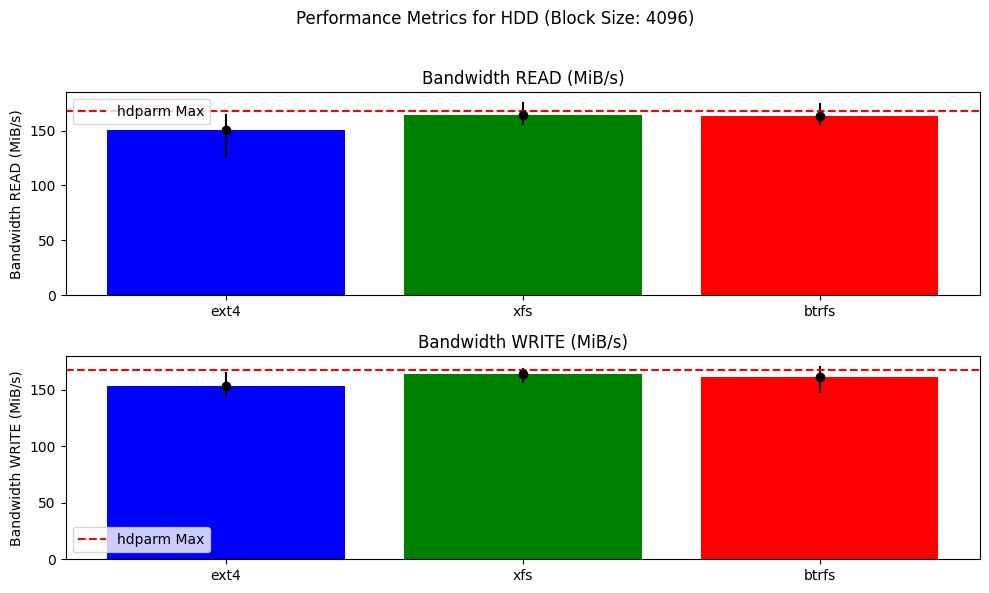

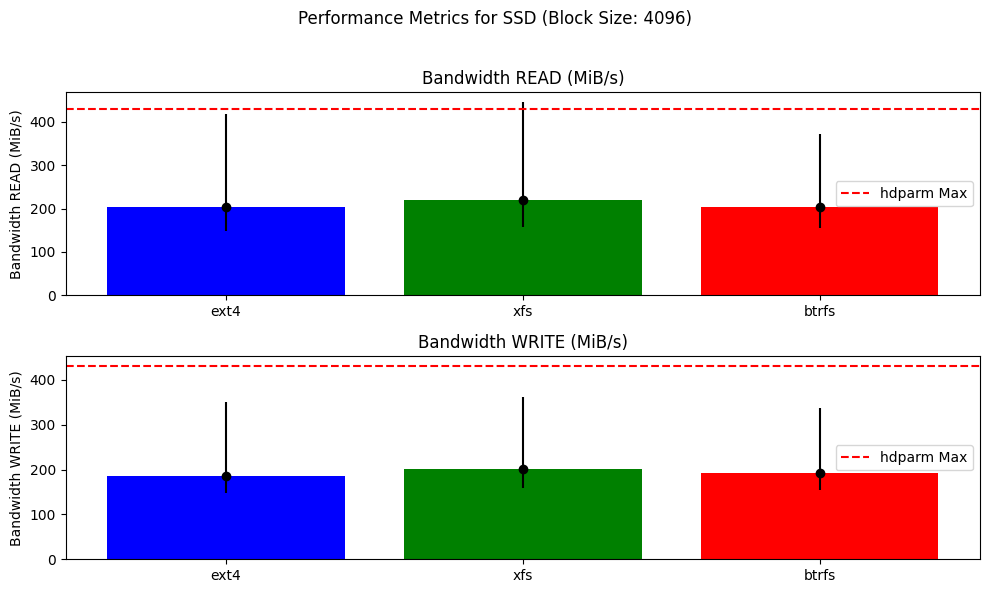

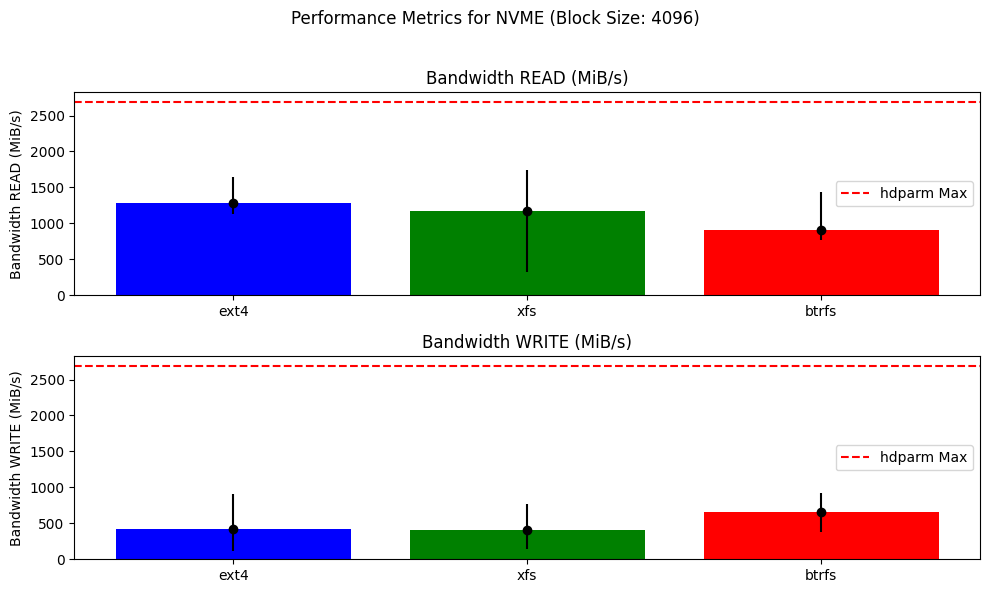

In [27]:

# Plot performance metrics for dd data
plot_performance_metrics(dd_resultsdict, metrics=["Bandwidth READ (MiB/s)", "Bandwidth WRITE (MiB/s)"], storage_types=storage_types, block_sizes=['4096']
, include_min_max=True, hdparm_data=hdparm_resultsdict, hdparm_stat='max' )

#TODO dodanie uniwersalnej funkcji fo tabelek

In [10]:
import pandas as pd

def generate_columns(metrics, stats=["MIN", "AVG", "MAX"], storage_types=["HDD", "SSD", "NVME"]):
    columns = ["File System", "Block Size"]
    for storage in storage_types:
        for metric in metrics:
            for stat in stats:
                columns.append(f"{storage} {metric} {stat}")
    return columns

def extract_row_data(data, workload, columns, file_systems=None, block_sizes=None):
    rows = []
    for fs, block_data in data.items():
        if file_systems and fs not in file_systems:
            continue
        for block_size, devices in block_data.items():
            if block_sizes and block_size not in block_sizes:
                continue
            row = [fs, block_size]
            for col in columns[2:]:  # Skip File System and Block Size
                if len(col.split()) > 3:
                    col = col.split()
                    storage, metric, stat = col[0], col[1] + ' ' + col[2], col[3]
                else:
                    storage, metric, stat = col.split(" ", 2)
                if workload == 'read':
                    metric_key = f"{metric} READ (MiB/s)" if "Bandwidth" in metric else f"{metric} READ"
                elif workload == 'write':
                    metric_key = f"{metric} WRITE (MiB/s)" if "Bandwidth" in metric else f"{metric} WRITE"
                else:
                    metric_key = f"{metric} (MiB/s)" if "Bandwidth" in metric else metric
                # Extract value
                value = "N/A"
                for device_type, workloads in devices.items():
                    if device_type.lower() == storage.lower() and workload in workloads:
                        value = workloads[workload].get(metric_key, {}).get(stat.lower(), "N/A")
                        break
                row.append(value)
            rows.append(row)
    return rows

def display_performance_metrics(data, workloads, metrics, stats=["MIN", "AVG", "MAX"], storage_types=["HDD", "SSD", "NVME"], file_systems=None, block_sizes=None):
    for workload in workloads:
        columns = generate_columns(metrics, stats, storage_types)
        rows = extract_row_data(data, workload, columns, file_systems, block_sizes)
        df = pd.DataFrame(rows, columns=columns)
        display(df.style.set_caption(f"Performance Metrics: {workload.capitalize()}").format(precision=3))

# Example usage for dd
dd_workloads = ["read", "write"]
dd_metrics = ["Bandwidth", "Time"]
block_sizes = ["4096"]  # Specify block sizes to display

# Generate and display tables for dd data
for workload in dd_workloads:
    display_performance_metrics(dd_resultsdict, [workload], dd_metrics, block_sizes=block_sizes)

,File System,Block Size,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD Time MIN,HDD Time AVG,HDD Time MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD Time MIN,SSD Time AVG,SSD Time MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME Time MIN,NVME Time AVG,NVME Time MAX
0,ext4,4096,125.000,150.170,165.000,N/A,N/A,N/A,148.000,202.900,419.000,N/A,N/A,N/A,1126.400,1290.240,1638.400,N/A,N/A,N/A
1,xfs,4096,155.000,164.300,176.000,N/A,N/A,N/A,157.000,220.100,446.000,N/A,N/A,N/A,322.000,1179.080,1740.800,N/A,N/A,N/A
2,btrfs,4096,154.000,163.700,175.000,N/A,N/A,N/A,156.000,204.200,371.000,N/A,N/A,N/A,766.000,903.760,1433.600,N/A,N/A,N/A


,File System,Block Size,HDD Bandwidth MIN,HDD Bandwidth AVG,HDD Bandwidth MAX,HDD Time MIN,HDD Time AVG,HDD Time MAX,SSD Bandwidth MIN,SSD Bandwidth AVG,SSD Bandwidth MAX,SSD Time MIN,SSD Time AVG,SSD Time MAX,NVME Bandwidth MIN,NVME Bandwidth AVG,NVME Bandwidth MAX,NVME Time MIN,NVME Time AVG,NVME Time MAX
0,ext4,4096,144.000,153.170,166.000,N/A,N/A,N/A,148.000,185.800,350.000,N/A,N/A,N/A,111.000,415.200,914.000,N/A,N/A,N/A
1,xfs,4096,156.000,163.700,169.000,N/A,N/A,N/A,158.000,201.400,361.000,N/A,N/A,N/A,149.000,404.200,766.000,N/A,N/A,N/A
2,btrfs,4096,147.000,161.500,171.000,N/A,N/A,N/A,155.000,191.600,337.000,N/A,N/A,N/A,375.000,654.200,918.000,N/A,N/A,N/A
